# Метод непрерывной идентификации по ФПГ
Я решил, что если нас учат иногда на Синтетике, то на синтетике можно и работу представить :)
В данном ноутбуке будет приведён пример реализации механизма непрерывной идентификации пользователя на основе т.н. "идентификации новизны" каждой новой эпохи измерения ФПГ пользователя. Следует отличать задачу поиска новизны от задачи поиска аномалий, так как измерения, которые хочется идентифицировать, как не относящиеся к оригинальному пользователю всё ещё будут валидными в плане представленных данных, то есть они будут формировать некоторый новый набор данных, вместо того чтобы быть "шумом" или не отражать предметную область задачи.

Описание метода:
- сгенерировать данные псевдопользователей
- записать исходный "эталонный" образец длиной в пять минут для сравнения с последующими измерениями
- вычислить для каждой эпохи интервалом в 10 секунд характеристики вариационной пульсометрии
- обучить один из алгоритмов поиска новизны:
  - [Local Outlier Factor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor)
  - [SGDOneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDOneClassSVM.html#sklearn.linear_model.SGDOneClassSVM)

- для каждой новой эпохи длиной в 10 секунд сформировать предсказание о её принадлежности к общему, уже виденному ранее, распределению либо о том, что новая эпоха не принадлежит "эталону" указанного пользователя

Стоит заметить, что для каждого пользователя и сеанса идентификации придётся обучать алгоритм заново, так как невозможно предсказать, как изменится состояние пользователя по данному биометрическому параметру в некотором будущем, чтобы утверждать, что обученный алгоритм будет пригоден для использования в другом сеансе идентификации

В работе также будут исследована эффективность каждого из доступных алгоритмов поиска новизны.

## Используемые библиотеки
- Scikit-learn
- Neurokit2
- matplotlib
- pandas
- numpy

# Генерация входных данных
Сгенерируем данные 10 эталонных 5-минутных записей пользователей так, чтобы
каждые 2 полученные ФПГ лежали в одной пульсовой зоне (примерно +- 10 уд/мин). Это позволит исследовать как влияние абсолютной частоты пульса, так и возможность разделения идентичных пульсов обученной моделью определения новизны.
Для этого используется широко известная в узких кругах библиотека NeuroKit2 (https://neuropsychology.github.io/NeuroKit/_modules/neurokit2/ppg/ppg_simulate.html)

In [1]:
!pip install neurokit2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.3 MB/s eta 0:00:00


In [5]:
import neurokit2 as nk
import random
from collections import namedtuple

answer_to_all_questions = 42
etalon_duration = 300
sample_rate = 250

random.seed(answer_to_all_questions)
low_pulse_bound = 65
pulse_step = 10

ppg_observations = dict()

for low_pulse in range(low_pulse_bound, low_pulse_bound+5*pulse_step,  pulse_step):
  ppgs = list()
  for _ in range(2):
    pulse_chosen = random.randint(low_pulse, low_pulse+pulse_step)
    ppg_data = nk.ppg_simulate(
            duration=etalon_duration,
            heart_rate=pulse_chosen,
            sampling_rate=sample_rate,
            random_state=answer_to_all_questions,
            ibi_randomness=0.3,
            motion_amplitude=0.3)
    ppgs.append(ppg_data)

  ppg_observations[f'up_to_{low_pulse+pulse_step}'] = ppgs



Проверим, что получилось на первых 10 секундах одного из измерений

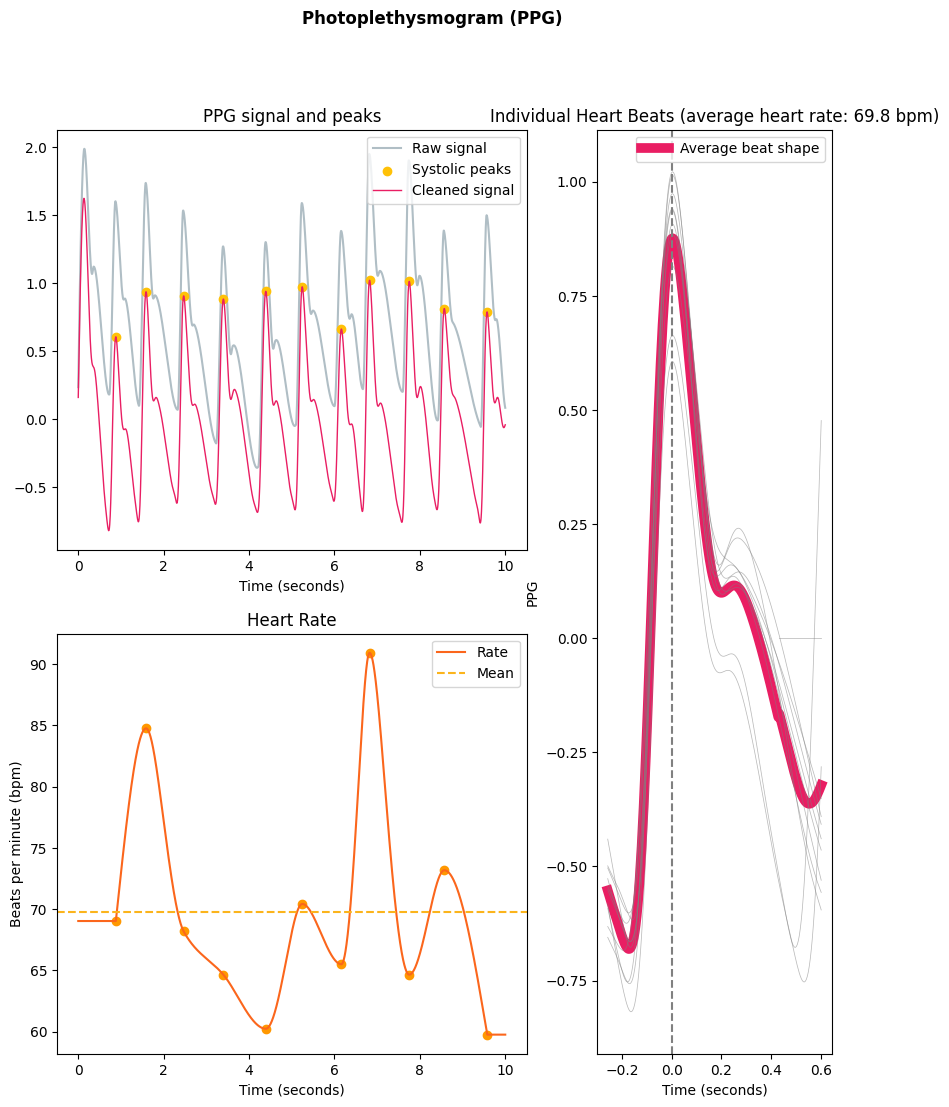

In [6]:
import matplotlib.pyplot as plt

signals, info = nk.ppg_process(
    ppg_observations['up_to_75'][0][:10*sample_rate],
    sampling_rate=sample_rate)

nk.ppg_plot(signals, info)
fig = plt.gcf()
fig.set_size_inches(10, 12, forward=True)

# Создание признакового пространства
Чтобы получить признаки, по которым можно было бы различать новизну данных, воспользуемся функционалом библиотеки neurokit2:
1. `ppg_process` - виполнить очистку и препроцессиннг ФПГ
2. `epochs_create` - нарезать сигнал на эпохи по 10 секунд
3. `ppg_intervalrelated` - извлечь 92 признака вариационной пульсометрии из каждой эпохи, которые и будут использоываться далее

In [7]:
import pandas as pd
import numpy as np

epoch_step_in_seconds = 20

ppg_features = dict(ppg_observations.items())
epochs_bounds = [epoch_bound for epoch_bound in range(0, etalon_duration*sample_rate-sample_rate*epoch_step_in_seconds, sample_rate)]
# print(epochs_bounds)

for key, ppg_observations_by_zone in ppg_features.items():
  ppg_features_by_zone = list()
  for ppg in ppg_observations_by_zone:
    df, info = nk.ppg_process(
        ppg_signal=ppg,
        sampling_rate=sample_rate
        )

    epochs = nk.epochs_create(
        df,
        events=epochs_bounds,
        sampling_rate=sample_rate,
        epochs_end=epoch_step_in_seconds
        )
    # print(epochs)
    features = nk.ppg_intervalrelated(epochs, sampling_rate=sample_rate).replace([-np.inf, np.inf], None).dropna(axis=1)
    ppg_features_by_zone.append(features)

  ppg_features[key] = ppg_features_by_zone

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.10/dist-packages/neurokit2/complexity/entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
/usr/local/lib/python3.10/dist-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/usr/local/lib/python3.10/dist-packages/neurokit2/complexity/entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
/usr/local/lib/python3.10/dist-packages/neurokit2/complexity/entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
/usr/local/lib/python3.10/dist-packages/ne

Далее можно выбрать признаки, которые есть у всех пульсовых зон и перенезначить Label для того, чтобы отличать одного пользователя от другого

In [8]:
common_columns = set(ppg_features['up_to_75'][0].columns)
for pulse_zone_name, features in ppg_features.items():
  for ppg_data in features:
    common_columns = common_columns.intersection(ppg_data.columns)

for pulse_zone_name, features in ppg_features.items():
  for i in range(2):
    features[i].loc[:,'Label'] = 1 if i==1 else -1
    ppg_features[pulse_zone_name][i] = features[i][list(common_columns)]



<ipython-input-8-c4de525e674d>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  features[i].loc[:,'Label'] = 1 if i==1 else -1
<ipython-input-8-c4de525e674d>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  features[i].loc[:,'Label'] = 1 if i==1 else -1
<ipython-input-8-c4de525e674d>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(

Полученные признаки

В датасете представлены признаки для каждой из 280 эпох длиной 20 секунд для пятиминутной эталонной записи

In [9]:
ppg_features['up_to_75'][0]

,HRV_HTI,HRV_MeanNN,HRV_pNN50,HRV_CSI_Modified,HRV_MinNN,HRV_CVNN,HRV_SDNNa,HRV_TINN,HRV_FuzzyEn,HRV_ShanEn,...,HRV_PSS,HRV_Ca,HRV_SD1d,HRV_Prc80NN,HRV_IALS,HRV_SDNNd,HRV_MFDFA_alpha1_Max,HRV_CD,HRV_SD2d,HRV_MedianNN
1,11.5,799.304348,69.565217,457.434649,596.0,0.142015,79.166755,164.0625,1.632711,4.175736,...,0.866667,0.472579,76.53695,916.0,0.681818,83.634237,-0.145356,1.48737,90.174644,764.0
2,12.0,800.0,62.5,467.638422,596.0,0.137454,77.552206,179.6875,1.472106,4.251629,...,0.9375,0.483347,70.147896,916.0,0.695652,80.179709,-0.562527,1.669569,89.088968,768.0
3,12.0,803.833333,66.666667,425.711468,596.0,0.142302,77.391169,179.6875,1.498895,4.251629,...,0.941176,0.473698,77.255185,920.8,0.73913,81.575145,0.092705,1.64091,85.677563,768.0
4,12.0,798.0,66.666667,352.148864,596.0,0.139484,81.681562,171.875,1.585726,4.334963,...,0.941176,0.554051,76.57201,916.0,0.73913,73.281065,-0.831007,1.667411,69.835207,768.0
5,12.0,791.666667,66.666667,303.542434,596.0,0.130877,74.940912,171.875,1.661544,4.334963,...,0.941176,0.507242,77.036001,877.6,0.73913,73.86315,-0.173125,1.675834,70.547745,768.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,8.0,799.333333,87.5,434.572032,612.0,0.134419,77.269994,140.625,1.755946,4.418296,...,1.0,0.501667,76.562512,889.6,0.695652,77.012833,0.435521,1.817087,77.460537,756.0
277,8.0,804.666667,87.5,400.559397,612.0,0.133914,74.004914,125.0,1.741122,4.334963,...,1.0,0.469783,79.260216,889.6,0.652174,78.621071,0.395515,1.741108,77.976686,762.0
278,7.666667,810.434783,86.956522,384.320363,612.0,0.131368,76.453534,125.0,1.643876,4.349649,...,1.0,0.499642,77.864351,894.4,0.681818,76.508325,0.416957,1.946597,75.127828,768.0
279,8.0,801.5,83.333333,415.77763,612.0,0.131232,74.805914,125.0,1.649022,4.418296,...,1.0,0.491891,76.476972,884.8,0.652174,76.029146,0.509125,2.003159,75.578666,762.0


# Подготовка данных для обучения и тестирования

- Колонка Label - цель предсказания
- Тренировочные данные для различных пульсовых зон уже готовы
- Тестовые данные создаются путём случайного перемешивания эпох входных данных для одной пульсовой зоны (перемешивать данные разных пульсовых зон не имеет смысла, так как такое значительное повышение пульса сразу может быть обнаружено и без сложного алгоритма поиска новизны)
Перемешивать предполагается интервалами от 10 секунд и больше, так  получится запись длиной 10 минут с последовательными интервалами, принадлежащими разным пользователям

На рисунке ниже представлено разбиение новой записи во времени для пульсовой зоны "до 115 уд/мин":

"1"-первый пользователь,

"-1"-новый пользователь

Text(0, 0.5, 'user')

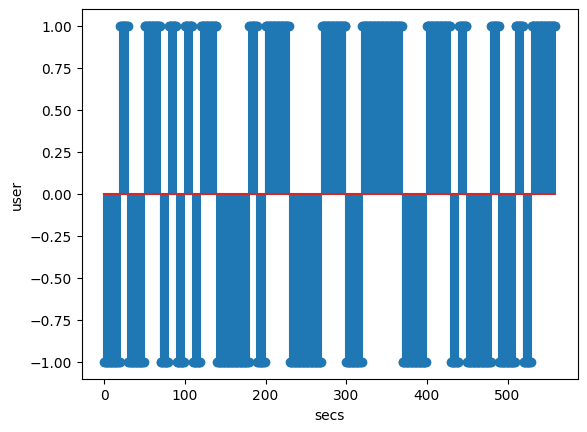

In [10]:
test_data = ppg_features.copy()
np.random.seed(42)

for pulse_zone_name, features in test_data.items():
  df = pd.concat(objs=features)
  df = df.values
  np.random.shuffle(df.reshape(-1, 10, df.shape[1]))
  test_data[pulse_zone_name] = pd.DataFrame(data=df, columns=list(common_columns))

plt.stem(test_data['up_to_75']['Label'])
plt.xlabel('secs')
plt.ylabel('user')

In [11]:
train_data = ppg_features.copy()

# Обучение моделей и расчёт метрики эффективности идентификации

Эффективность идентификации будем оценивать в основном по метрике recall, так как нам необходимо не доспустить случая взлома

## LocalOutlierFactor

In [12]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report

recalls = []

for pulse_zone_name, (intruder, auth_user) in train_data.items():
  lof = LocalOutlierFactor(novelty=True, n_neighbors=20)
  lof.fit(auth_user.drop('Label', axis=1).values)
  y_pred = lof.predict(test_data[pulse_zone_name].drop('Label', axis=1).values)
  report = classification_report(y_pred=list(y_pred),
                                 y_true=list(test_data[pulse_zone_name]['Label'].values),
                                 output_dict=False,
                                 target_names=['intruder', 'auth_user'])
  print(pulse_zone_name)
  print(report)



up_to_75
              precision    recall  f1-score   support

    intruder       0.87      0.47      0.61       280
   auth_user       0.64      0.93      0.75       280

    accuracy                           0.70       560
   macro avg       0.75      0.70      0.68       560
weighted avg       0.75      0.70      0.68       560

up_to_85
              precision    recall  f1-score   support

    intruder       0.89      0.20      0.32       280
   auth_user       0.55      0.97      0.70       280

    accuracy                           0.59       560
   macro avg       0.72      0.59      0.51       560
weighted avg       0.72      0.59      0.51       560

up_to_95
              precision    recall  f1-score   support

    intruder       0.50      0.03      0.05       280
   auth_user       0.50      0.97      0.66       280

    accuracy                           0.50       560
   macro avg       0.50      0.50      0.36       560
weighted avg       0.50      0.50      0.36    

С увеличением пульса отделить взломщика от авторизованного пользователя становится всё сложней, в итоге recall со значения 0.47 на пульсе до 75 ударов падает практически до нуля c ростом ЧСС


Таким образом, в рамках выполнения задания было показано, что при помощи средств вариационной пульсометрии и алгоритма поиска новизны в данных не удаётся достичь необходимой точности решения.
